# PDE-FIND for the Quantum Harmonic Oscillator

By Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on the schrodinger equation with a parabolic well potential.  
$$
iu_t = \frac{-1}{2}u_{xx} + \frac{x^2}{2}u
$$
We assume full knowledge of the complex wave function rather than just the squared magnitude and also know that there is a potenital function $\frac{x^2}{2}$, but it is unknown if or how it appears in the PDE.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import PDE_FIND 
import scipy.io as sio
import timeit
import imp
imp.reload(PDE_FIND)

<module 'PDE_FIND' from '/Users/zack/Documents/oscillators/manybody/PDE_FIND.py'>

In [2]:
# Load data - solution to schrodinger in parabolic well
data = sio.loadmat('harmonic_osc.mat')
np.random.seed(1)
u = data['usol'][::2,::2]
#Adding some noise to the data. Maybe this is not the best kind of noise for our purposes...
u = u + 0.0*np.random.randn(u.shape[0], u.shape[1])
x = data['x'][0][::2]
t = data['t'][:,0][::2]
dt = t[1] - t[0]
dx = x[1] - x[0]
n = len(x)
m = len(t)

In [3]:
potential = np.vstack([0.5*np.power(x,2).reshape((1,n)) for _ in range(m)])

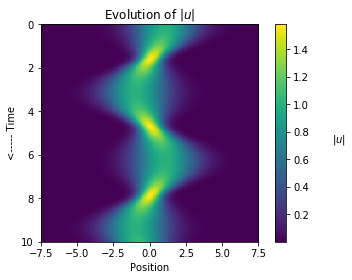

In [4]:
plt.imshow(abs(u),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('$|u|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")
plt.title("Evolution of $|u|$")
plt.show()

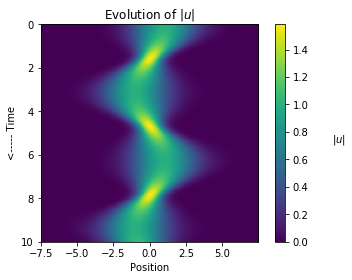

In [71]:
times=np.fromfile("times.dat")
grid=np.fromfile("grid.dat")
vals=np.fromfile("vals.dat")

dat=np.reshape(vals[::2]+1j*vals[1::2],(len(times),len(grid)))
plt.imshow(abs(dat),extent=(grid[0],grid[-1],times[-1],times[0]),aspect=1.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('$|u|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")
plt.title("Evolution of $|u|$")
plt.show()

In [89]:
u = dat[::2,::2] + 0.0*np.random.randn(u.shape[0], u.shape[1])
x = grid[::2]
t = times[::2]
dt = t[1] - t[0]
dx = x[1] - x[0]
n = len(x)
m = len(t)

## Build Library of Candidate Terms

We first differentiate the data along the spatial and temporal directions and construct a library of terms including nonlinearities and partial derivatives.  The matrix Theta is constructed so that each column is a potential term in the PDE, listed below.

In [91]:
start=timeit.default_timer()

ut = np.zeros((m-10,n-10), dtype=np.complex64)
ux = np.zeros((m-10,n-10), dtype=np.complex64)
uxx = np.zeros((m-10,n-10), dtype=np.complex64)
uxxx = np.zeros((m-10,n-10), dtype=np.complex64)

for i in range(n-10):
    pdr=PDE_FIND.PolyDiff(np.real(u[:,i+5]), dt*np.arange(m), diff=1)
    pdi=PDE_FIND.PolyDiff(np.imag(u[:,i+5]), dt*np.arange(m), diff=1)
    ut[:,i] = pdr[:,0]+1j*pdi[:,0]
for i in range(m-10):
    pdr=PDE_FIND.PolyDiff(np.real(u[i+5,:]), np.arange(n), diff=3)
    pdi=PDE_FIND.PolyDiff(np.imag(u[i+5,:]), np.arange(n), diff=3)
    ux[i,:]=pdr[:,0]+1j*pdi[:,0]
    uxx[i,:]=pdr[:,1]+1j*pdi[:,1]
    uxxx[i,:]=pdr[:,2]+1j*pdi[:,2]
    
ut = np.reshape(ut, ((n-10)*(m-10),1), order='F')
ux = np.reshape(ux, ((n-10)*(m-10),1), order='F')
uxx = np.reshape(uxx, ((n-10)*(m-10),1), order='F')
uxxx = np.reshape(uxxx, ((n-10)*(m-10),1), order='F')

X_ders = np.hstack([np.ones(((n-10)*(m-10),1)),ux,uxx,uxxx])
X_data = np.hstack([np.reshape(u[5:-5,5:-5], ((n-10)*(m-10),1), order='F'), 
                    np.reshape(abs(u[5:-5,5:-5]), ((n-10)*(m-10),1), order='F'), 
                    np.reshape(potential[5:-5,5:-5], ((n-10)*(m-10),1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

X, descr = PDE_FIND.build_Theta(X_data, X_ders, derivatives_description, 2, data_description = ['u','|u|','V'])

stop=timeit.default_timer()
print("Runtime:", stop-start)

Runtime: 103.12329766600033


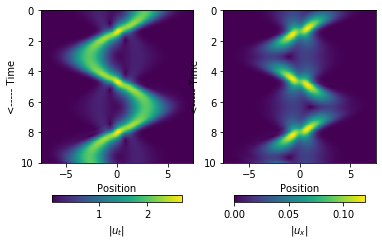

In [92]:
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.imshow(np.abs(np.reshape(ut,(m-10,n-10),order='F')),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_t|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")

plt.subplot(1,2,2)
plt.imshow(np.abs(np.reshape(ux,(m-10,n-10),order='F')),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_x|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")


plt.show()

## Parameter Sweep over $\lambda$ with Fixed d_tol. Trained on all data (i.e. train + test).

In [93]:
imp.reload(PDE_FIND)

start=timeit.default_timer()

ErrorData=[]
# Iterate over lambda (range found to be reasonably good via trial and error)
for _ in np.linspace(0.001,0.05,25):
    print(_)
    
    # Call TrainSTRidge with fixed tolerance
    temp=PDE_FIND.TrainSTRidge(X,ut,_,10)
    
    # Save number of nonzero terms, test error, lambda, training error
    ErrorData.append([np.count_nonzero(temp[0]),temp[1],_,temp[2]])

ErrorData=np.array(ErrorData)
stop=timeit.default_timer()
print("Runtime:", stop-start)

0.001
0.003041666666666667
0.005083333333333334
0.007125
0.009166666666666667
0.011208333333333334
0.013250000000000001
0.015291666666666669
0.017333333333333336
0.019375000000000003
0.02141666666666667
0.023458333333333338
0.025500000000000002
0.02754166666666667
0.029583333333333336
0.031625
0.03366666666666667
0.035708333333333335
0.037750000000000006
0.03979166666666667
0.04183333333333334
0.043875000000000004
0.045916666666666675
0.04795833333333334
0.05
Runtime: 95.13792322500012


In [94]:
PDE_FIND.print_pde(PDE_FIND.TrainSTRidge(X,ut,0.01,10)[0],descr)

u_t = (-2.284255 +150.223888i)u_{xx}
    + (0.015749 -0.982565i)uV
   


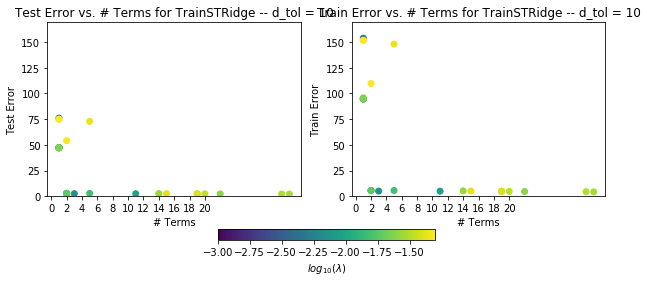

In [96]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

plot=ax[0].scatter(ErrorData[:,0],ErrorData[:,1],c=np.log10(ErrorData[:,2]))
ax[0].set_xlabel("# Terms")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[0].set_xticks(range(0,22,2))
ax[0].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])

plot=ax[1].scatter(ErrorData[:,0],ErrorData[:,3],c=np.log10(ErrorData[:,2]))
ax[1].set_xlabel("# Terms")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[1].set_xticks(range(0,22,2))
ax[1].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])


cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('$log_{10}(\lambda)$')

plt.show()

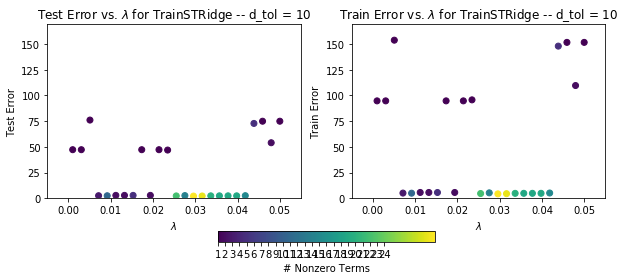

In [97]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(ErrorData[:,2],ErrorData[:,1],c=ErrorData[:,0])
ax[0].set_xlabel("$\lambda$")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[0].set_xlim([-0.005,0.055])
ax[0].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])


plot=ax[1].scatter(ErrorData[:,2],ErrorData[:,3],c=ErrorData[:,0])
ax[1].set_xlabel("$\lambda$")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[1].set_xlim([-0.005,0.055])
ax[1].set_ylim([0,1.1*np.max(ErrorData[:,[1,3]])])

cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('# Nonzero Terms')
cbar.set_ticks(np.arange(0,25,1))

plt.show()

## Repeat Parameter Sweep, but Only Train on Training Data

In [88]:
def TrainSTRidge2(R, Ut, lam, d_tol, maxit = 25, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8, print_best_tol = False):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them 
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolerance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]       

    # Set up the initial tolerance and l0 penalty –– NOTE: This is the "L"0 penalty, not the "ten" penalty!!
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        #print(f"TrainSTRidge iteration {iter}: tol = {tol}")
        
        # Get a set of coefficients and error
        w = PDE_FIND.STRidge(TrainR,TrainY,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            tol = tol + d_tol

    if print_best_tol: print("Optimal tolerance: %f"%(tol_best))

    return w_best, np.linalg.norm(TestY - TestR.dot(w_best), 2), np.linalg.norm(TrainY - TrainR.dot(w_best), 2)


In [ ]:
imp.reload(PDE_FIND)

start=timeit.default_timer()

ErrorData2=[]
for _ in np.linspace(0.001,0.05,25):
    print(_)
    temp=TrainSTRidge2(X,ut,_,10)
    ErrorData2.append([np.count_nonzero(temp[0]),temp[1],_,temp[2]])
stop=timeit.default_timer()

ErrorData2=np.array(ErrorData2)
stop=timeit.default_timer()
print("Runtime:", stop-start)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

plot=ax[0].scatter(ErrorData2[:,0],ErrorData2[:,1],c=np.log10(ErrorData2[:,2]))
ax[0].set_xlabel("# Terms")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[0].set_xticks(range(0,22,2))
ax[0].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])

plot=ax[1].scatter(ErrorData2[:,0],ErrorData2[:,3],c=np.log10(ErrorData2[:,2]))
ax[1].set_xlabel("# Terms")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. # Terms for TrainSTRidge -- d_tol = 10")
ax[1].set_xticks(range(0,22,2))
ax[1].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])


cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('$log_{10}(\lambda)$')

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(ErrorData2[:,2],ErrorData2[:,1],c=ErrorData2[:,0])
ax[0].set_xlabel("$\lambda$")
ax[0].set_ylabel("Test Error")
ax[0].set_title("Test Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[0].set_xlim([-0.005,0.055])
ax[0].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])


plot=ax[1].scatter(ErrorData2[:,2],ErrorData2[:,3],c=ErrorData2[:,0])
ax[1].set_xlabel("$\lambda$")
ax[1].set_ylabel("Train Error")
ax[1].set_title("Train Error vs. $\lambda$ for TrainSTRidge -- d_tol = 10")
ax[1].set_xlim([-0.005,0.055])
ax[1].set_ylim([0,1.1*np.max(ErrorData2[:,[1,3]])])

cbar = fig.colorbar(plot, ax=ax.ravel().tolist(),orientation="horizontal",fraction=0.05)
cbar.ax.set_xlabel('# Nonzero Terms')
cbar.set_ticks(np.arange(0,25,1))

plt.show()

In [ ]:
#Do the sweeps with stridge (not trainstridge), and plot a training and testing error.